In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import tqdm
import pickle

import robustness_model

/Users/sang-geon/Documents/UCI_BIASLab/HDC_Robustness/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = datasets.MNIST(root = './datasets/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './datasets/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

number of training data :  60000
number of test data :  10000


In [3]:
X_train = train_data.data
y_train = train_data.targets
X_test = test_data.data
y_test = test_data.targets

In [4]:
X_train = X_train[(y_train == 0) | (y_train == 1)].reshape(-1, 28*28) / 255
y_train = y_train[(y_train == 0) | (y_train == 1)]
X_test = X_test[(y_test == 0) | (y_test == 1)].reshape(-1, 28*28) / 255
y_test = y_test[(y_test == 0) | (y_test == 1)]

In [5]:
original_dim = 28*28
dim = 10000

In [6]:
def overall_robustness_method3(model: robustness_model.ClassificationModel, X):
    
    ep3s = []

    max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=10000, show_pbar=False) # 2000

    for x in X:
        ep3 = model.get_eps(x, L3)
        ep3s.append(ep3)
    
    return torch.tensor(ep3s).mean()

In [7]:
def train(X, y, sample_size=10, lr=0.001, epochs=50, B=0., amplify=1., device='cpu'):

    X = X.to(device)
    y = y.to(device)

    theta = torch.nn.parameter.Parameter(torch.randn(1, device=device)[0].abs() + 1) # theta = (0, sigma) = (sigma)
    print(theta)
    # optimizer = torch.optim.Adam([theta], lr=lr)
    optimizer = torch.optim.SGD([theta], lr=lr)

    loss_history = []
    loss_gradient_values = []
    theta_history = []
    epsilon_history = []

    with tqdm.tqdm(total=epochs) as pbar:

        for i in range(epochs):

            optimizer.zero_grad()

            dists = torch.distributions.Normal(torch.tensor(0.0, device=device), theta)
            samples = dists.sample(sample_shape=torch.Size((sample_size, dim, original_dim)))
            
            epsilons = []
            for sample in samples:
                encoder = robustness_model.FHRREncoder(original_dim, dim, M=sample*amplify, device=device)
                model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim, device=device)
                model.bundling(X, y) # X_train, y_train

                epsilon = overall_robustness_method3(model, X) # X_train
                epsilons.append(epsilon)
            epsilons = torch.tensor(epsilons)

            # REINFORCE
            loss = sum((epsilon.item() - B) * dists.log_prob(sample).mean() for epsilon, sample in zip(epsilons, samples)) / sample_size
            loss = -loss# .mean()
            loss.backward()

            optimizer.step()

            loss_history.append(loss.item())
            loss_gradient_values.append(theta.grad.item())
            theta_history.append(theta.item())
            epsilon_history.append(epsilons.mean().item())

            pbar.update(1)
            pbar.set_postfix({
                'Loss': loss.item(),
                'Theta': theta.item(),
                'Epsilon': epsilons.mean().item(),
            })

    return loss_history, loss_gradient_values, theta_history, epsilon_history


In [10]:
# amplify + SGD
sample_size = 30
lr = 10000.
epochs = 30

for trial in range(10):
    print('trial', trial)

    loss_history, loss_gradient_values, theta_history, epsilon_history = train(X_test, y_test, sample_size=sample_size, lr=lr, epochs=epochs, B=0., amplify=1., device='cpu')

    fig, axes = plt.subplots(1, 4, dpi=100, figsize=(25, 6))
    axes[0].set_title('Loss history')
    axes[0].plot(loss_history)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[1].set_title('Gradient history')
    axes[1].plot(loss_gradient_values)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Gradient')
    axes[2].set_title('Theta ($\sigma$) history')
    axes[2].plot(theta_history)
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('$\sigma$')
    axes[3].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
    axes[3].plot(epsilon_history)
    axes[3].set_xlabel('Iteration')
    axes[3].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
    fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
    fig.tight_layout()
    plt.show()

trial 0
Parameter containing:
tensor(1.2079, requires_grad=True)


 23%|██▎       | 7/30 [3:04:22<10:09:20, 1589.58s/it, Loss=0.0248, Theta=1.21, Epsilon=0.0154]

In [40]:
dists = torch.distributions.Normal(torch.tensor(0.0, device='cpu'), 1.)
samples = dists.sample(sample_shape=torch.Size((30, dim, original_dim)))
samples

tensor([[[-7.2722e-02, -1.0487e+00,  4.7027e-01,  ..., -2.1994e+00,
          -3.0261e-01, -1.3253e+00],
         [ 1.4190e+00, -1.5273e+00,  4.4147e-01,  ..., -1.5131e+00,
           8.3793e-01, -2.5388e-01],
         [ 1.3036e-01, -1.4942e-01,  1.2457e+00,  ...,  4.4912e-01,
           6.7793e-01,  7.7725e-01],
         ...,
         [-2.0255e+00,  1.3965e-01,  1.0760e+00,  ...,  7.4118e-01,
          -6.0791e-01, -3.5749e-01],
         [ 7.6075e-01,  1.1905e+00,  2.5332e+00,  ...,  9.8815e-01,
           1.5169e+00, -1.3986e+00],
         [ 1.0300e+00,  2.1920e+00, -9.8638e-01,  ...,  1.6575e+00,
          -8.4913e-02,  2.5738e-02]],

        [[-1.1530e+00,  1.4554e+00, -7.0357e-01,  ..., -8.4039e-01,
           3.6742e-02, -1.5753e+00],
         [ 1.0252e+00, -1.0096e+00, -1.2991e+00,  ..., -1.9617e+00,
           3.2695e-01, -5.9344e-02],
         [-7.5926e-02,  8.1412e-01,  1.2276e+00,  ...,  3.5205e-01,
           1.3291e+00, -2.1089e-01],
         ...,
         [ 4.2878e-03,  4

In [9]:
samples.shape

torch.Size([30, 10000, 784])

In [13]:
samples[0]

tensor([[ 0.2755, -1.4301,  0.3607,  ...,  0.3460, -0.4619, -1.9092],
        [ 0.3785,  0.0791,  0.9672,  ...,  1.3476, -0.1483, -2.1112],
        [-0.1984,  0.0928,  0.2753,  ..., -0.0795,  1.3211,  1.5318],
        ...,
        [ 0.5923, -0.4869,  0.0399,  ..., -0.5844,  0.4594, -0.3823],
        [ 0.9741, -1.2813,  0.2740,  ..., -1.5263, -0.6267, -0.5658],
        [-0.7332, -0.2812, -0.6952,  ...,  0.3906,  1.3015, -0.6937]])

In [12]:
dists.log_prob(samples[0])

tensor([[-0.9569, -1.9415, -0.9840,  ..., -0.9788, -1.0256, -2.7415],
        [-0.9906, -0.9221, -1.3867,  ..., -1.8269, -0.9299, -3.1474],
        [-0.9386, -0.9232, -0.9568,  ..., -0.9221, -1.7916, -2.0921],
        ...,
        [-1.0943, -1.0375, -0.9197,  ..., -1.0897, -1.0245, -0.9920],
        [-1.3934, -1.7397, -0.9565,  ..., -2.0837, -1.1153, -1.0790],
        [-1.1877, -0.9585, -1.1606,  ..., -0.9952, -1.7659, -1.1595]])

In [56]:
theta = torch.tensor(1., requires_grad=True)
dists = torch.distributions.Normal(torch.tensor(0.0, device='cpu'), theta)
samples = dists.sample(sample_shape=torch.Size((30, dim, original_dim)))

arr = []
for i in range(30):
    mean_abs_diff = samples[i].abs().mean()
    mean_log_porb = dists.log_prob(samples[i]).mean()
    mean_log_porb.backward()
    gradient = theta.grad
    arr.append((mean_abs_diff, mean_log_porb.item(), gradient.item()))
arr.sort()
for x in arr:
    print(x)

(tensor(0.7972), -1.4180384874343872, -0.00017851591110229492)
(tensor(0.7975), -1.4186543226242065, 0.0008379220962524414)
(tensor(0.7977), -1.4187147617340088, -0.0006262063980102539)
(tensor(0.7977), -1.4188346862792969, 0.002809762954711914)
(tensor(0.7978), -1.4188462495803833, 0.0026250481605529785)
(tensor(0.7978), -1.4189866781234741, 0.0025085806846618652)
(tensor(0.7979), -1.4188505411148071, 0.0024486184120178223)
(tensor(0.7979), -1.4189660549163818, 0.0008927583694458008)
(tensor(0.7979), -1.4187191724777222, 0.0026584267616271973)
(tensor(0.7979), -1.4188934564590454, 0.0007761716842651367)
(tensor(0.7979), -1.4188635349273682, -0.00038170814514160156)
(tensor(0.7979), -1.4189488887786865, -0.0002315044403076172)
(tensor(0.7979), -1.419114589691162, 0.0016217827796936035)
(tensor(0.7979), -1.4189351797103882, 0.0006031394004821777)
(tensor(0.7979), -1.4190272092819214, 0.0020235776901245117)
(tensor(0.7980), -1.4189127683639526, 0.0014066100120544434)
(tensor(0.7980), -1.

In [62]:
theta = torch.tensor(1., requires_grad=True)
dists = torch.distributions.Normal(torch.tensor(0.0, device='cpu'), theta)
samples = dists.sample(sample_shape=torch.Size((30, dim, original_dim)))

arr = []
for i in range(30):
    mean_abs_diff = samples[i].abs().mean()
    mean_log_porb = dists.log_prob(samples[i]).mean()
    #mean_log_porb.backward(retain_graph=True)
    gradient = torch.autograd.grad(mean_log_porb, theta, retain_graph=True)
    arr.append((mean_abs_diff, mean_log_porb.item(), gradient))
arr.sort()
for x in arr:
    print(x)

(tensor(0.7975), -1.4186471700668335, (tensor(-0.0006),))
(tensor(0.7976), -1.4185960292816162, (tensor(-0.0007),))
(tensor(0.7976), -1.4187102317810059, (tensor(-0.0005),))
(tensor(0.7976), -1.4186424016952515, (tensor(-0.0006),))
(tensor(0.7977), -1.4187099933624268, (tensor(-0.0005),))
(tensor(0.7977), -1.4186474084854126, (tensor(-0.0006),))
(tensor(0.7977), -1.4186817407608032, (tensor(-0.0005),))
(tensor(0.7977), -1.4186912775039673, (tensor(-0.0005),))
(tensor(0.7977), -1.4188780784606934, (tensor(-0.0001),))
(tensor(0.7977), -1.4187335968017578, (tensor(-0.0004),))
(tensor(0.7977), -1.4188685417175293, (tensor(-0.0001),))
(tensor(0.7978), -1.4188834428787231, (tensor(-0.0001),))
(tensor(0.7978), -1.4189908504486084, (tensor(0.0001),))
(tensor(0.7978), -1.4188538789749146, (tensor(-0.0002),))
(tensor(0.7978), -1.4189130067825317, (tensor(-5.1260e-05),))
(tensor(0.7979), -1.4190516471862793, (tensor(0.0002),))
(tensor(0.7979), -1.4190278053283691, (tensor(0.0002),))
(tensor(0.797

In [9]:
theta = torch.tensor(1., requires_grad=True)
dists = torch.distributions.Normal(torch.tensor(0.0), theta)
samples = dists.sample(sample_shape=torch.Size((30, dim, original_dim)))

arr = []
for i in tqdm.tqdm(range(30)):
    mean_abs_diff = samples[i].abs().mean()

    encoder = robustness_model.FHRREncoder(original_dim, dim, M=samples[i])
    model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
    model.bundling(X_test, y_test) # X_train, y_train
    epsilon = overall_robustness_method3(model, X_test) # X_train

    mean_log_porb = epsilon.item() * dists.log_prob(samples[i]).mean() * 100.
    #mean_log_porb.backward(retain_graph=True)
    gradient = torch.autograd.grad(mean_log_porb, theta, retain_graph=True)

    arr.append((mean_abs_diff.item(), mean_log_porb.item(), gradient[0].item(), epsilon.item()))
arr.sort()
for x in arr:
    print(x)

sum([g for _, _, g, _ in arr])

100%|██████████| 30/30 [06:44<00:00, 13.49s/it]

(0.7973641157150269, -3.210683584213257, -0.0029561519622802734, 0.022637778893113136)
(0.7975271940231323, -3.2409462928771973, -0.0016431808471679688, 0.02284643054008484)
(0.7975724339485168, -5.787076950073242, -0.004289150238037109, 0.040799662470817566)
(0.797607421875, -19.89498519897461, -0.007927894592285156, 0.14023825526237488)
(0.7976442575454712, -28.81993293762207, -0.00963592529296875, 0.20314303040504456)
(0.7976558804512024, -3.206925868988037, -0.001422882080078125, 0.02260589227080345)
(0.7976584434509277, -3.239760160446167, -0.0004980564117431641, 0.022834032773971558)
(0.7976704239845276, -3.358976125717163, -0.0009799003601074219, 0.023675905540585518)
(0.7977086901664734, -3.2268662452697754, -0.0006330013275146484, 0.02274364046752453)
(0.7977392077445984, -3.776409864425659, -0.0006895065307617188, 0.026616761460900307)
(0.7977810502052307, -3.930807590484619, -0.0007104873657226562, 0.027704956009984016)
(0.7977999448776245, -9.835675239562988, -0.00130796432

-0.014448165893554688

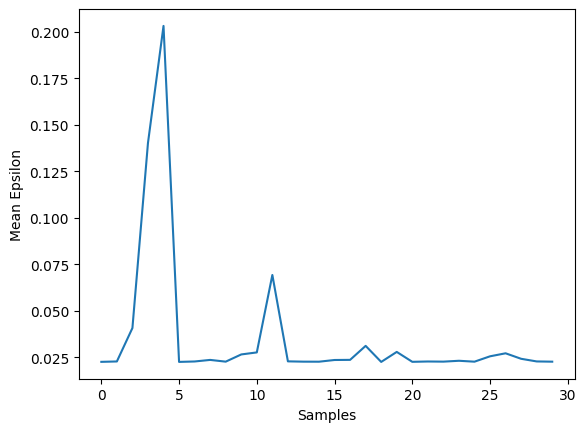

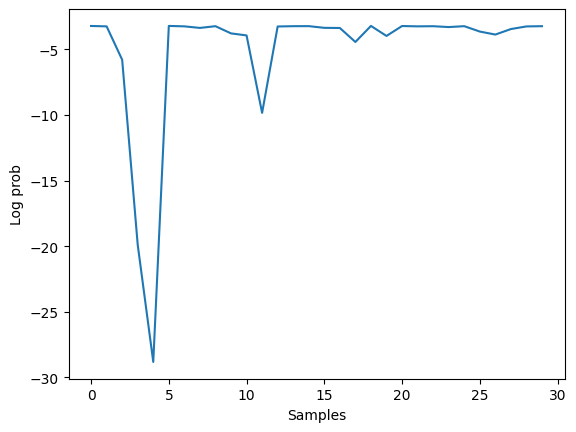

In [11]:
plt.plot([epsilon for _, _, _, epsilon in arr])
plt.xlabel('Samples')
plt.ylabel('Mean Epsilon')
plt.show()

plt.plot([mean_log_prob for _, mean_log_prob, _, _ in arr])
plt.xlabel('Samples')
plt.ylabel('Log prob')
plt.show()

In [16]:
theta = torch.tensor(10., requires_grad=True)
dists = torch.distributions.Normal(torch.tensor(0.0), theta)
samples = dists.sample(sample_shape=torch.Size((30, dim, original_dim)))

arr = []
for i in tqdm.tqdm(range(30)):
    mean_abs_diff = samples[i].abs().mean()

    encoder = robustness_model.FHRREncoder(original_dim, dim, M=samples[i] * 100)
    model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
    model.bundling(X_test, y_test) # X_train, y_train
    epsilon = overall_robustness_method3(model, X_test) # X_train

    mean_log_porb = epsilon.item() * dists.log_prob(samples[i]).mean() * 100.
    #mean_log_porb.backward(retain_graph=True)
    gradient = torch.autograd.grad(mean_log_porb, theta, retain_graph=True)

    arr.append((mean_abs_diff.item(), mean_log_porb.item(), gradient[0].item(), epsilon.item()))
arr.sort()
for x in arr:
    print(x)

sum([g for _, _, g, _ in arr])

100%|██████████| 30/30 [06:36<00:00, 13.22s/it]

(7.97629976272583, -156.16322326660156, -0.003029346466064453, 0.4196624457836151)
(7.97668981552124, -157.73081970214844, -0.0019164085388183594, 0.42385974526405334)
(7.977079391479492, -166.36300659179688, -0.0015387535095214844, 0.44704994559288025)
(7.97725248336792, -162.9230499267578, -0.001953601837158203, 0.43781206011772156)
(7.977267265319824, -159.427978515625, -0.0011744499206542969, 0.4284101724624634)
(7.977674961090088, -167.4851837158203, -0.0006761550903320312, 0.45005378127098083)
(7.977797508239746, -161.91729736328125, 7.152557373046875e-06, 0.435083270072937)
(7.977985858917236, -172.27235412597656, -0.0004940032958984375, 0.46291467547416687)
(7.978116035461426, -165.54481506347656, -0.0009198188781738281, 0.4448430836200714)
(7.9782795906066895, -164.30010986328125, -0.0003809928894042969, 0.4414913058280945)
(7.978353023529053, -158.062255859375, -0.0024886131286621094, 0.42475804686546326)
(7.978363037109375, -166.43650817871094, 0.0003733634948730469, 0.44722

0.007068634033203125

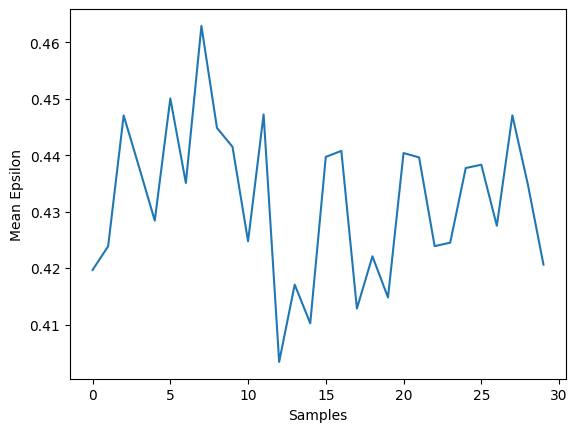

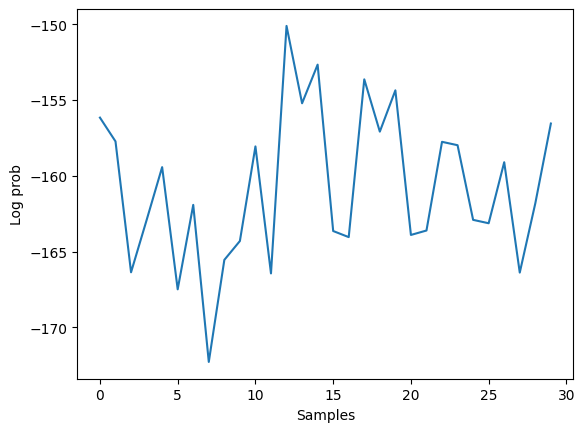

In [17]:
plt.plot([epsilon for _, _, _, epsilon in arr])
plt.xlabel('Samples')
plt.ylabel('Mean Epsilon')
plt.show()

plt.plot([mean_log_prob for _, mean_log_prob, _, _ in arr])
plt.xlabel('Samples')
plt.ylabel('Log prob')
plt.show()

In [18]:
theta = torch.tensor(10., requires_grad=True)
dists = torch.distributions.Normal(torch.tensor(0.0), theta)
samples = dists.sample(sample_shape=torch.Size((30, dim, original_dim)))

arr = []
for i in tqdm.tqdm(range(30)):
    mean_abs_diff = samples[i].abs().mean()

    encoder = robustness_model.FHRREncoder(original_dim, dim, M=samples[i] * 100)
    model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
    model.bundling(X_test, y_test) # X_train, y_train
    epsilon = overall_robustness_method3(model, X_test) # X_train

    mean_log_porb = epsilon.item() * dists.log_prob(samples[i]).mean() * 100.
    #mean_log_porb.backward(retain_graph=True)
    gradient = torch.autograd.grad(mean_log_porb, theta, retain_graph=True)

    arr.append((mean_abs_diff.item(), mean_log_porb.item(), gradient[0].item(), epsilon.item()))
arr.sort()
for x in arr:
    print(x)

sum([g for _, _, g, _ in arr])

100%|██████████| 30/30 [06:56<00:00, 13.89s/it]

(7.974871635437012, -159.133056640625, -0.005300998687744141, 0.4276730716228485)
(7.976667404174805, -156.9177703857422, -0.0005927085876464844, 0.4216572940349579)
(7.976834774017334, -165.5265350341797, -0.0008392333984375, 0.4447929859161377)
(7.976889610290527, -169.21334838867188, -0.001965045928955078, 0.45471471548080444)
(7.977308750152588, -169.61663818359375, -0.0025877952575683594, 0.45580679178237915)
(7.977423667907715, -157.77001953125, -0.0014677047729492188, 0.42395907640457153)
(7.9777913093566895, -151.95004272460938, 3.9577484130859375e-05, 0.40830013155937195)
(7.977974891662598, -161.79641723632812, -0.0019655227661132812, 0.4347849488258362)
(7.977989673614502, -161.6144561767578, -0.00019073486328125, 0.4342721402645111)
(7.9781880378723145, -148.53334045410156, -0.0005216598510742188, 0.39912673830986023)
(7.978248119354248, -157.65328979492188, -0.0010828971862792969, 0.4236401915550232)
(7.978627681732178, -157.8887939453125, 0.0007581710815429688, 0.42424830

0.010354995727539062

In [20]:
theta = torch.tensor(1.5, requires_grad=True)
dists = torch.distributions.Normal(torch.tensor(0.0), theta)
samples = dists.sample(sample_shape=torch.Size((30, dim, original_dim)))

arr = []
for i in tqdm.tqdm(range(30)):
    mean_abs_diff = samples[i].abs().mean()

    encoder = robustness_model.FHRREncoder(original_dim, dim, M=samples[i] * 100)
    model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
    model.bundling(X_test, y_test) # X_train, y_train
    epsilon = overall_robustness_method3(model, X_test) # X_train

    mean_log_porb = epsilon.item() * dists.log_prob(samples[i]).mean() * 100.
    #mean_log_porb.backward(retain_graph=True)
    gradient = torch.autograd.grad(mean_log_porb, theta, retain_graph=True)

    arr.append((mean_abs_diff.item(), mean_log_porb.item(), gradient[0].item(), epsilon.item()))
arr.sort()
for x in arr:
    print(x)

sum([g for _, _, g, _ in arr])

100%|██████████| 30/30 [06:40<00:00, 13.35s/it]

(1.196307897567749, -67.02969360351562, -0.019977569580078125, 0.36748817563056946)
(1.1963646411895752, -67.81497955322266, -0.008762359619140625, 0.3717464506626129)
(1.1964333057403564, -69.58631134033203, -0.014194488525390625, 0.38147789239883423)
(1.1964776515960693, -70.89095306396484, -0.020814895629882812, 0.3886561095714569)
(1.1964795589447021, -67.12543487548828, -0.017690658569335938, 0.3680035471916199)
(1.1965605020523071, -65.73795318603516, -0.013711929321289062, 0.3603821396827698)
(1.1965839862823486, -66.05111694335938, -0.010396957397460938, 0.3620850145816803)
(1.1966756582260132, -67.73170471191406, -0.0029354095458984375, 0.3712659776210785)
(1.1966941356658936, -65.59978485107422, -0.0006847381591796875, 0.3595712184906006)
(1.1967031955718994, -66.10603332519531, -0.009988784790039062, 0.36238428950309753)
(1.1967413425445557, -69.17794036865234, -0.0046749114990234375, 0.3792003393173218)
(1.1967666149139404, -60.42115783691406, -0.008579254150390625, 0.33121

0.024332046508789062

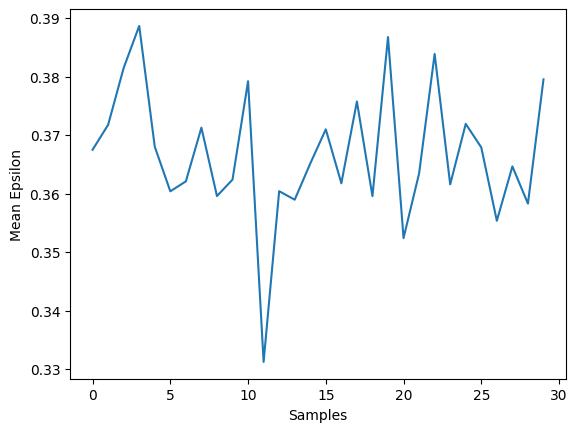

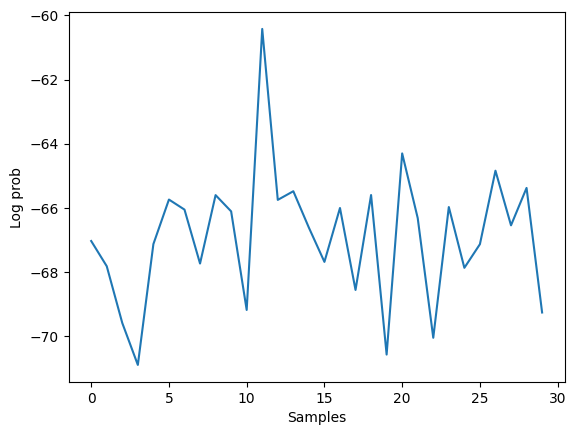

In [21]:
plt.plot([epsilon for _, _, _, epsilon in arr])
plt.xlabel('Samples')
plt.ylabel('Mean Epsilon')
plt.show()

plt.plot([mean_log_prob for _, mean_log_prob, _, _ in arr])
plt.xlabel('Samples')
plt.ylabel('Log prob')
plt.show()

trial 0
Parameter containing:
tensor(1.3193, requires_grad=True)


100%|██████████| 30/30 [3:32:51<00:00, 425.72s/it, Loss=0.639, Theta=1.42, Epsilon=0.365]  


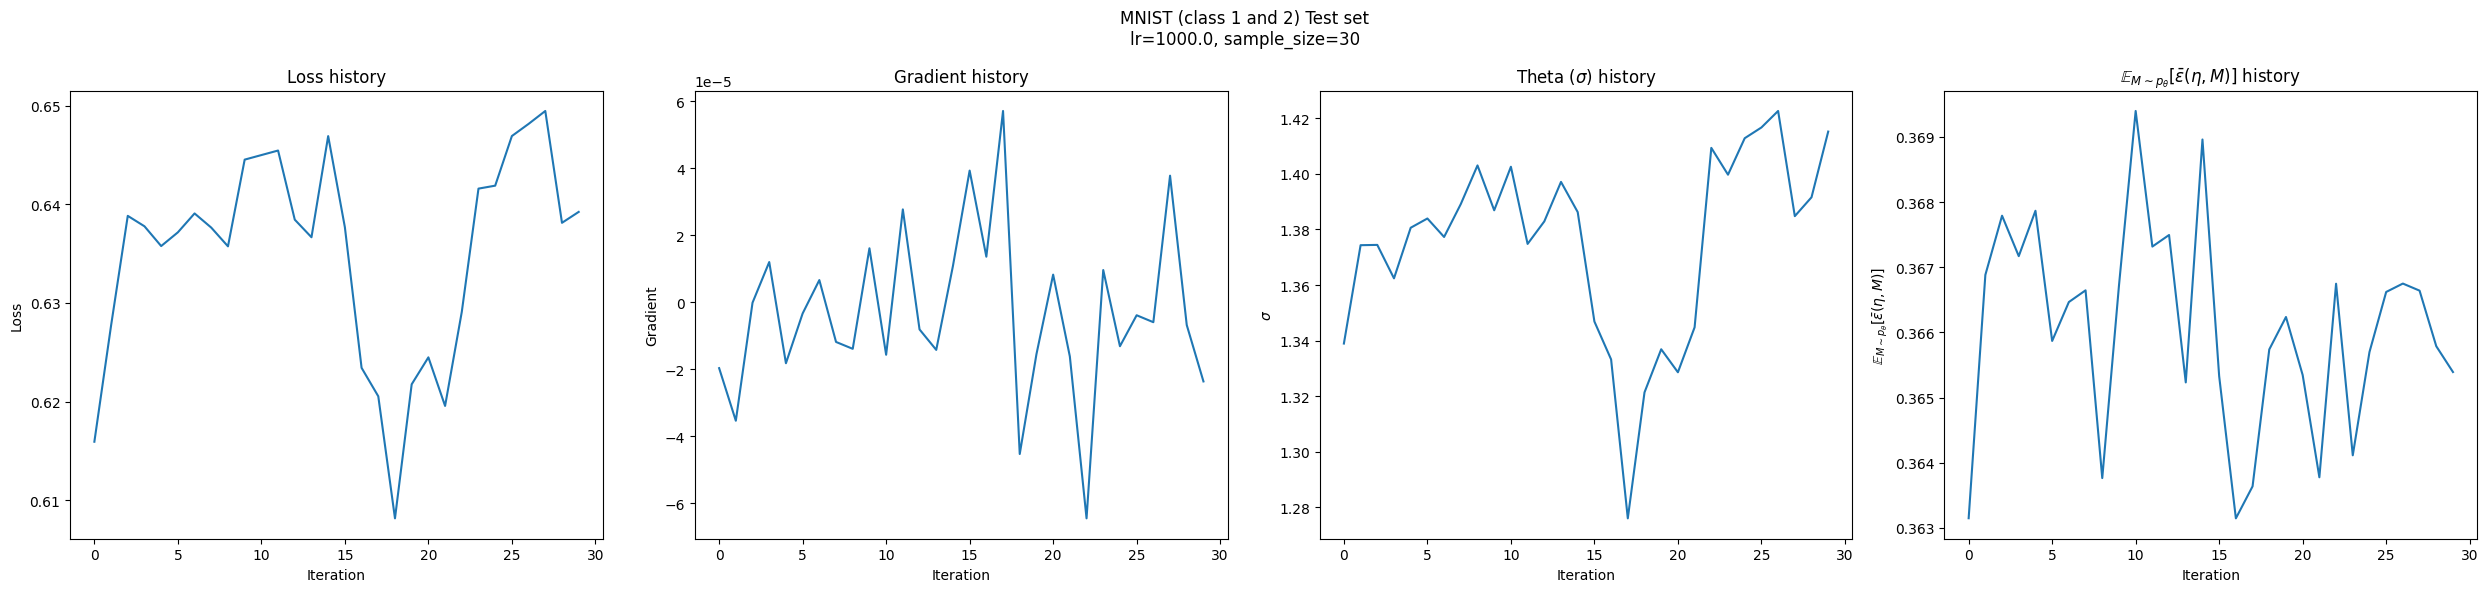

trial 1
Parameter containing:
tensor(1.0090, requires_grad=True)


 27%|██▋       | 8/30 [57:29<2:38:07, 431.24s/it, Loss=0.508, Theta=0.947, Epsilon=0.366]


KeyboardInterrupt: 

In [24]:
# amplify + SGD
sample_size = 30
lr = 1000.
epochs = 30

for trial in range(10):
    print('trial', trial)

    loss_history, loss_gradient_values, theta_history, epsilon_history = train(X_test, y_test, sample_size=sample_size, lr=lr, epochs=epochs, B=0., amplify=100., device='cpu')

    fig, axes = plt.subplots(1, 4, dpi=100, figsize=(25, 6))
    axes[0].set_title('Loss history')
    axes[0].plot(loss_history)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[1].set_title('Gradient history')
    axes[1].plot(loss_gradient_values)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Gradient')
    axes[2].set_title('Theta ($\sigma$) history')
    axes[2].plot(theta_history)
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('$\sigma$')
    axes[3].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
    axes[3].plot(epsilon_history)
    axes[3].set_xlabel('Iteration')
    axes[3].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
    fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
    fig.tight_layout()
    plt.show()

trial 0
Parameter containing:
tensor(1.7580, requires_grad=True)


100%|██████████| 30/30 [3:22:16<00:00, 404.53s/it, Loss=0.936, Theta=2.98, Epsilon=0.37]   


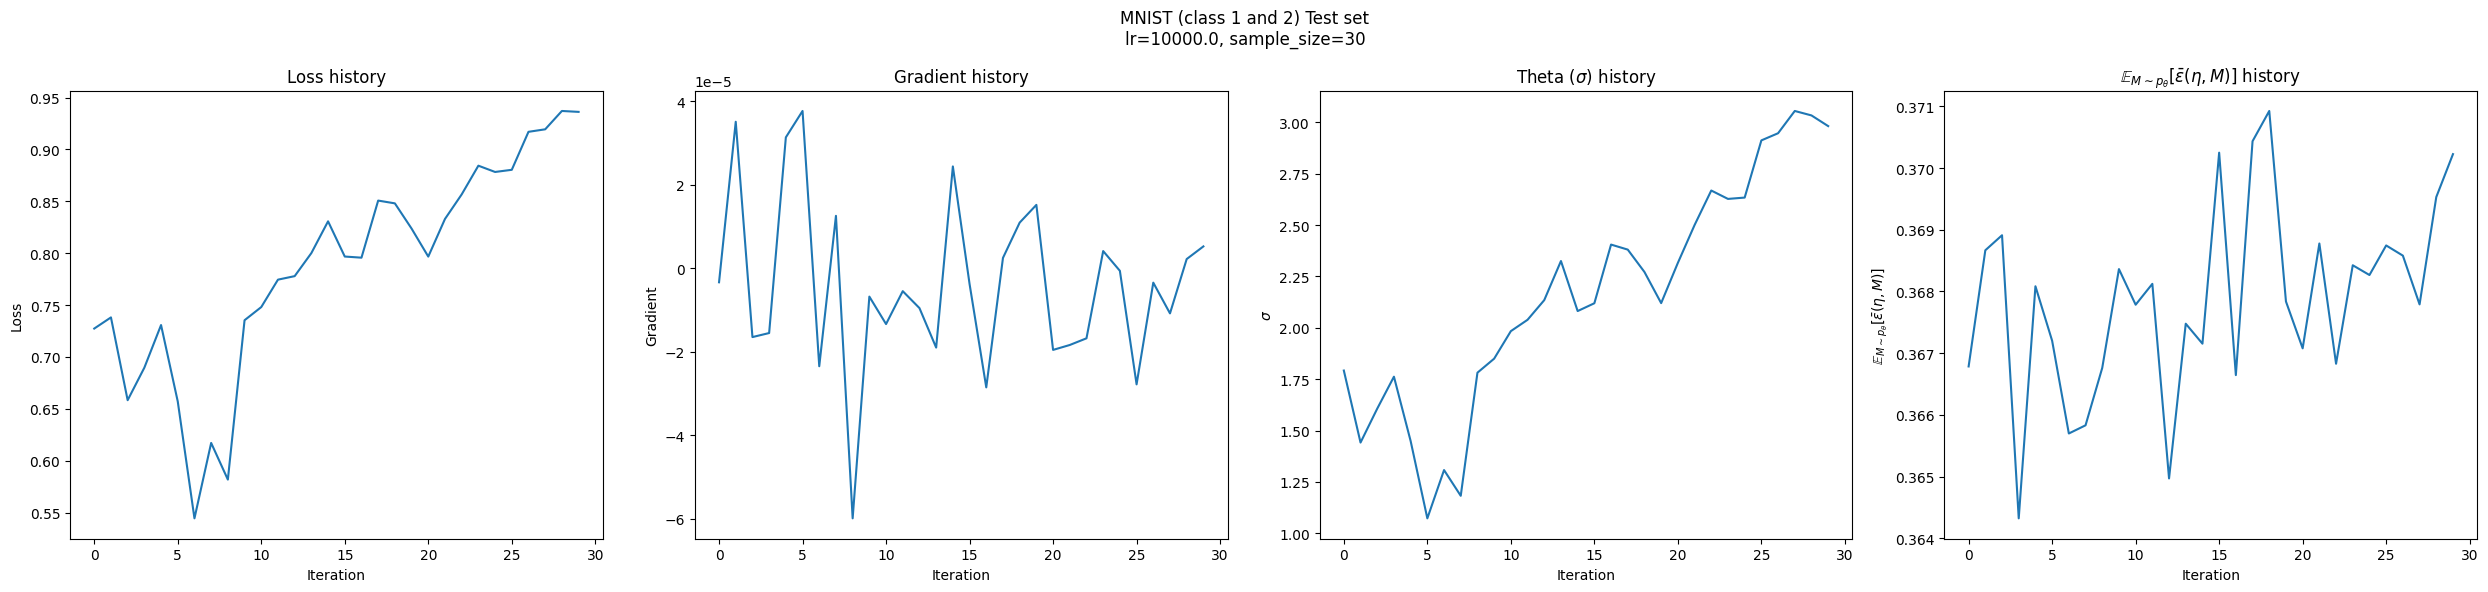

trial 1
Parameter containing:
tensor(1.5210, requires_grad=True)


100%|██████████| 30/30 [3:30:09<00:00, 420.33s/it, Loss=0.959, Theta=3.09, Epsilon=0.37]   


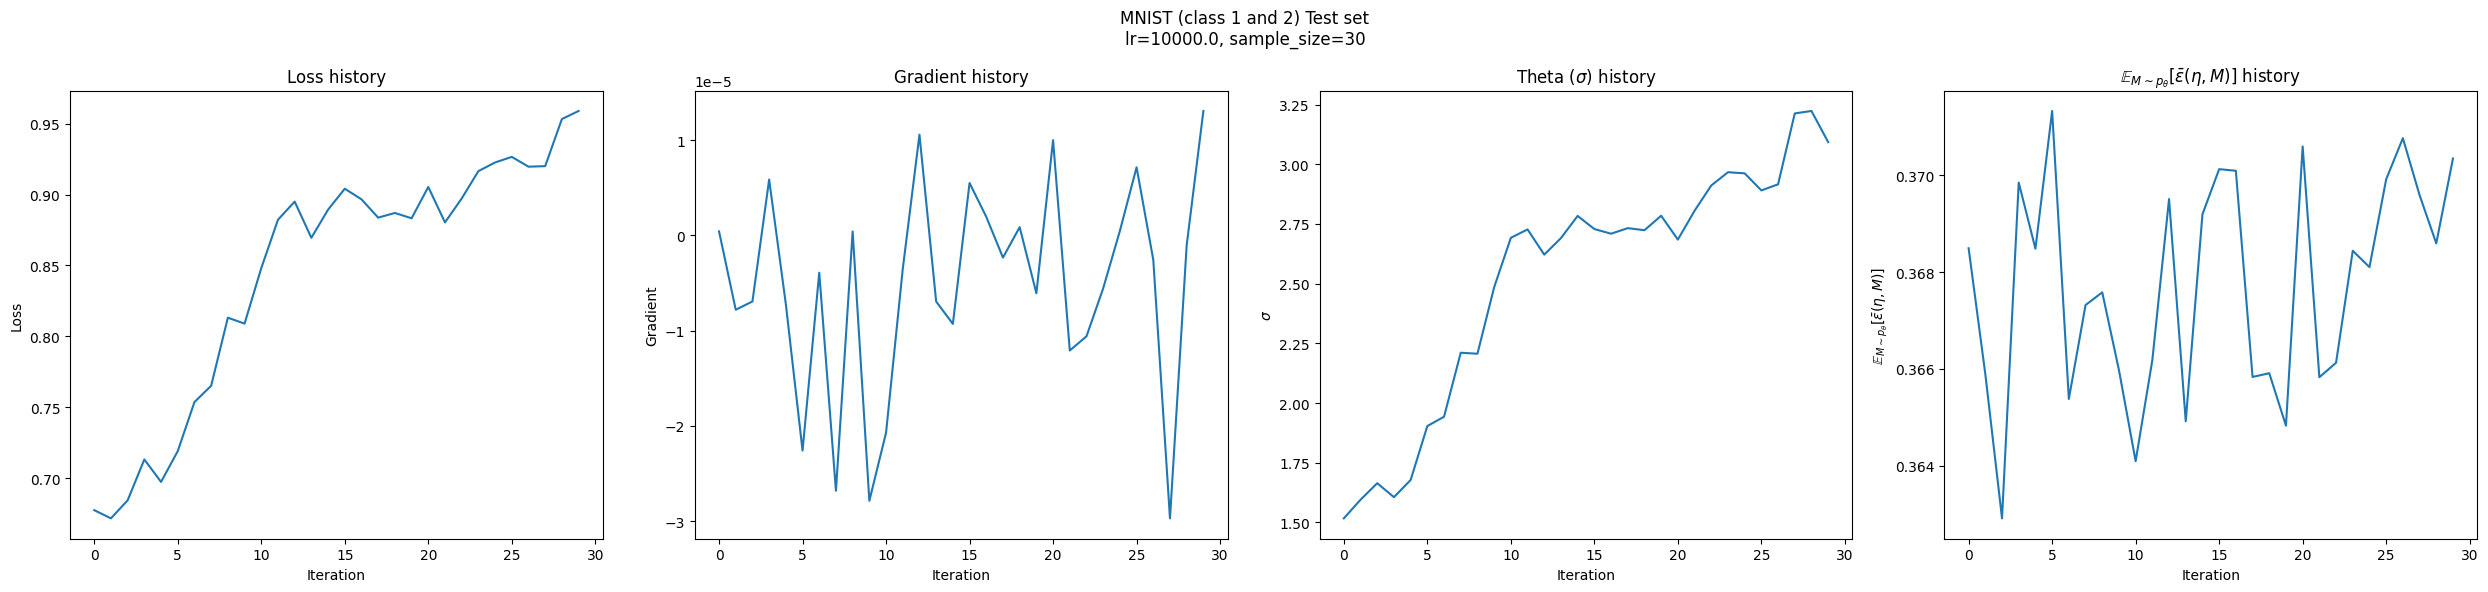

trial 2
Parameter containing:
tensor(2.3041, requires_grad=True)


 90%|█████████ | 27/30 [4:10:02<27:46, 555.66s/it, Loss=0.855, Theta=2.49, Epsilon=0.365]   


KeyboardInterrupt: 

In [25]:
# amplify + SGD
sample_size = 30
lr = 10000.
epochs = 30

for trial in range(10):
    print('trial', trial)

    loss_history, loss_gradient_values, theta_history, epsilon_history = train(X_test, y_test, sample_size=sample_size, lr=lr, epochs=epochs, B=0., amplify=100., device='cpu')

    fig, axes = plt.subplots(1, 4, dpi=100, figsize=(25, 6))
    axes[0].set_title('Loss history')
    axes[0].plot(loss_history)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[1].set_title('Gradient history')
    axes[1].plot(loss_gradient_values)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Gradient')
    axes[2].set_title('Theta ($\sigma$) history')
    axes[2].plot(theta_history)
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('$\sigma$')
    axes[3].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
    axes[3].plot(epsilon_history)
    axes[3].set_xlabel('Iteration')
    axes[3].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
    fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
    fig.tight_layout()
    plt.show()

In [8]:
# positive + SGD
sample_size = 50
lr = 1000.
epochs = 30

for trial in range(1):
    print('trial', trial)

    loss_history, loss_gradient_values, theta_history, epsilon_history = train(X_test, y_test, sample_size=sample_size, lr=lr, epochs=epochs, B=0., device='cpu')

    fig, axes = plt.subplots(1, 4, dpi=100, figsize=(25, 6))
    axes[0].set_title('Loss history')
    axes[0].plot(loss_history)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[1].set_title('Gradient history')
    axes[1].plot(loss_gradient_values)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Gradient')
    axes[2].set_title('Theta ($\sigma$) history')
    axes[2].plot(theta_history)
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('$\sigma$')
    axes[3].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
    axes[3].plot(epsilon_history)
    axes[3].set_xlabel('Iteration')
    axes[3].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
    fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
    fig.tight_layout()
    plt.show()


trial 0
Parameter containing:
tensor(1.3455, requires_grad=True)


  3%|▎         | 1/30 [08:42<4:12:35, 522.61s/it, Loss=0.485, Theta=1.34, Epsilon=0.283]

In [17]:
dists.log_prob(samples[0]).mean(), dists.log_prob(samples[1]).mean(), dists.log_prob(samples[2]).mean()

(tensor(-1.4190), tensor(-1.4189), tensor(-1.4188))

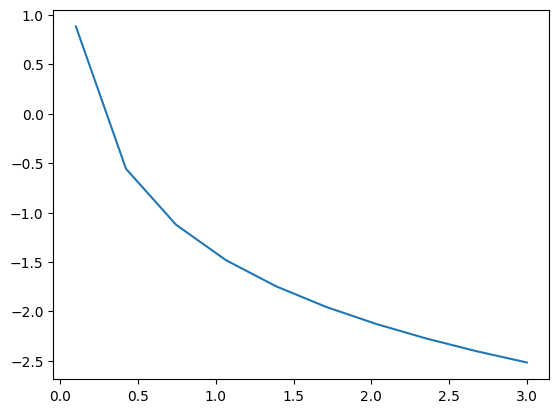

In [20]:
logprobs = []
thetas = torch.linspace(0.1, 3, steps=10)
for theta in thetas:
    dists = torch.distributions.Normal(torch.tensor(0.0, device='cpu'), theta)
    samples = dists.sample(sample_shape=torch.Size((30, dim, original_dim)))

    logprob = dists.log_prob(samples).mean()
    logprobs.append(logprob.item())

plt.plot(thetas, logprobs)
plt.show()

In [21]:
dists = torch.distributions.Normal(torch.tensor(0.0, device='cpu'), 1)

In [25]:
dists.log_prob(torch.tensor(10)), dists.log_prob(torch.tensor(0)), dists.log_prob(torch.tensor(0.5))

(tensor(-50.9189), tensor(-0.9189), tensor(-1.0439))

In [38]:
dists = torch.distributions.Normal(torch.tensor(0.0, device='cpu'), 20)

In [39]:
dists.log_prob(torch.tensor(10)), dists.log_prob(torch.tensor(0)), dists.log_prob(torch.tensor(0.5))

(tensor(-4.0397), tensor(-3.9147), tensor(-3.9150))

trial 0


100%|██████████| 50/50 [22:17:28<00:00, 1604.97s/it, Loss=-558, Theta=0.00547, Epsilon=146]       


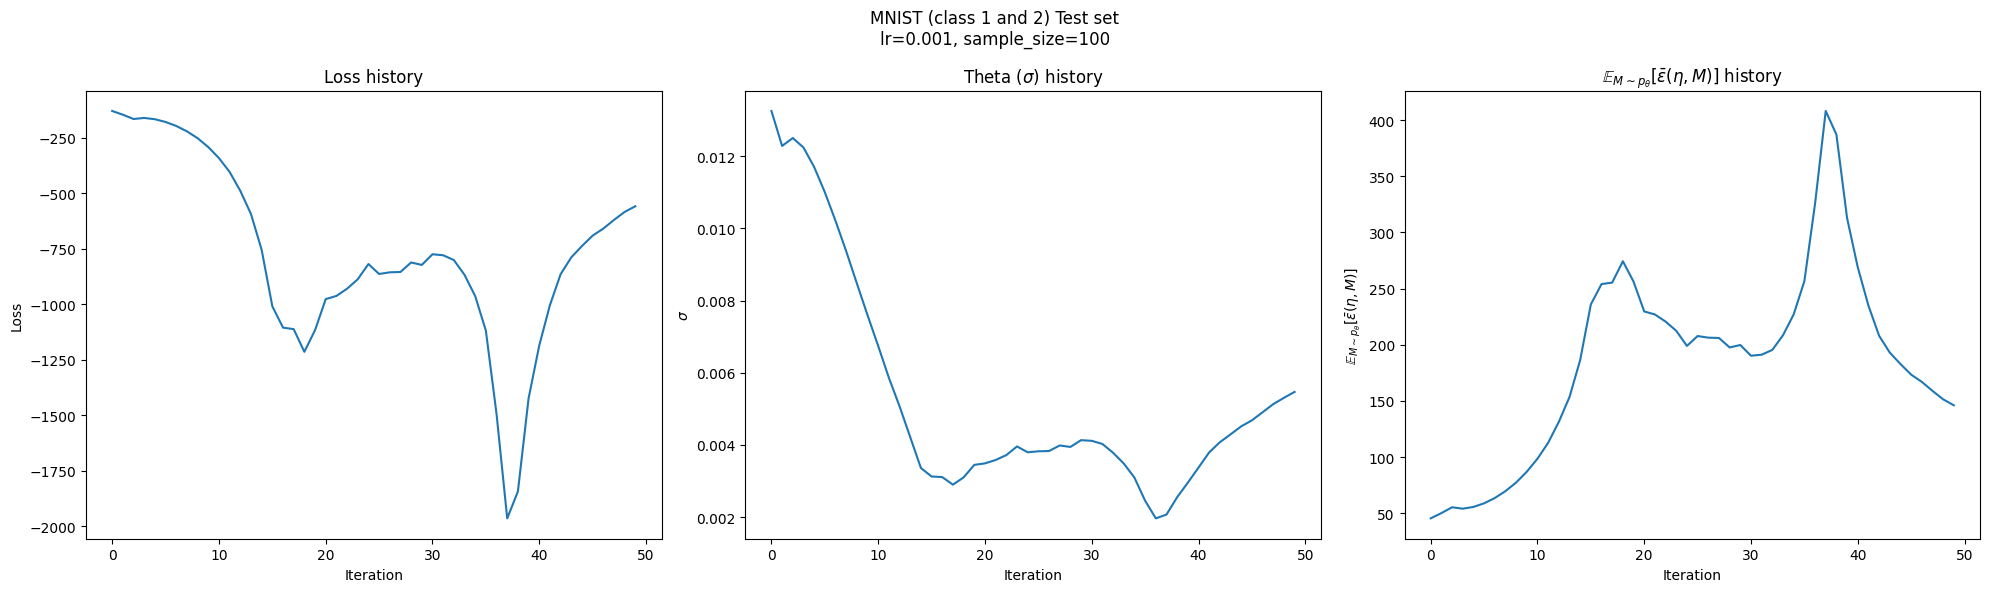

trial 1


100%|██████████| 50/50 [15:09:48<00:00, 1091.76s/it, Loss=0.595, Theta=1.58, Epsilon=0.317]  


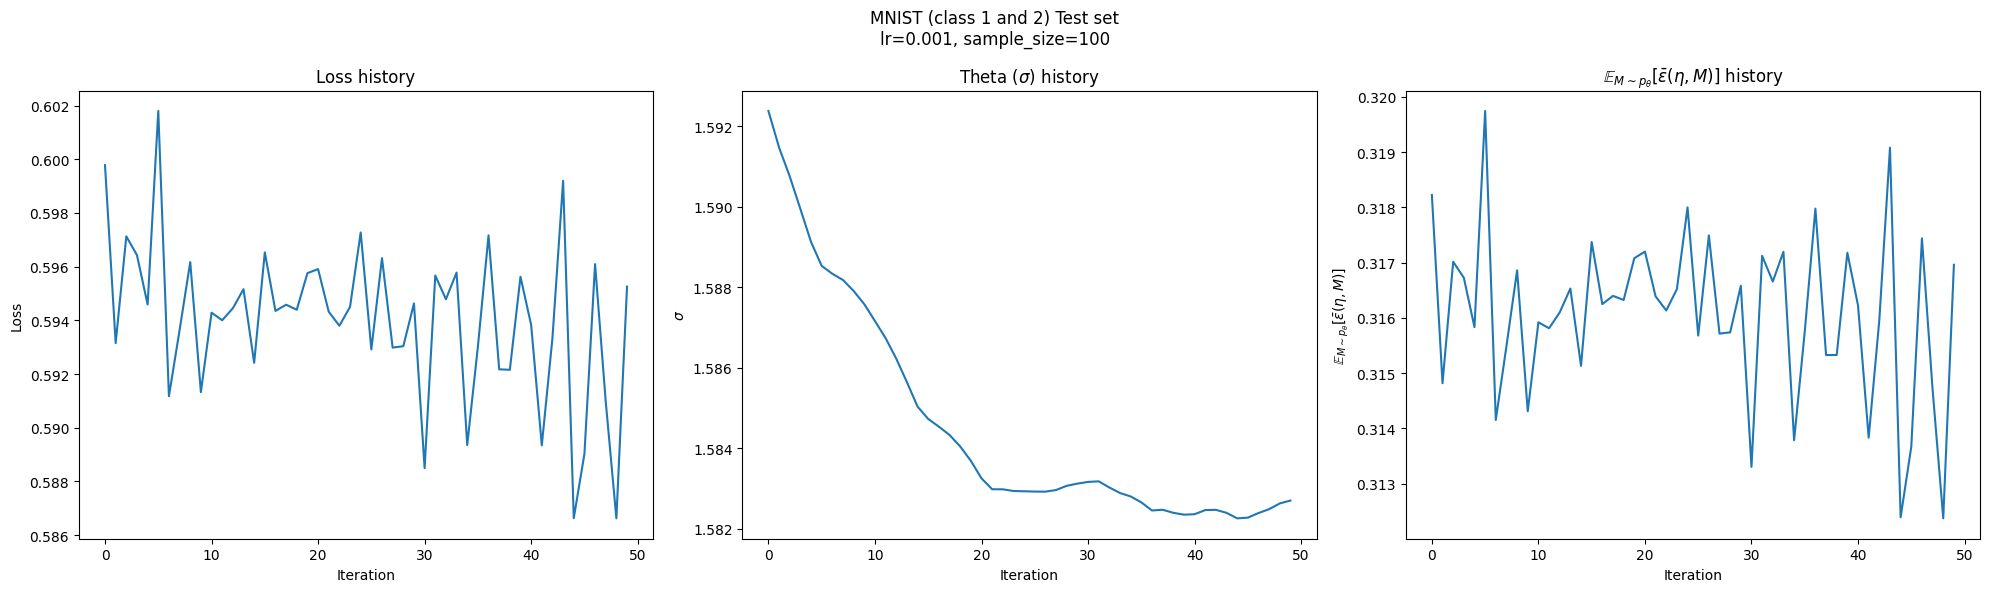

trial 2


100%|██████████| 50/50 [15:28:39<00:00, 1114.39s/it, Loss=-4.91, Theta=0.0711, Epsilon=4.01]  


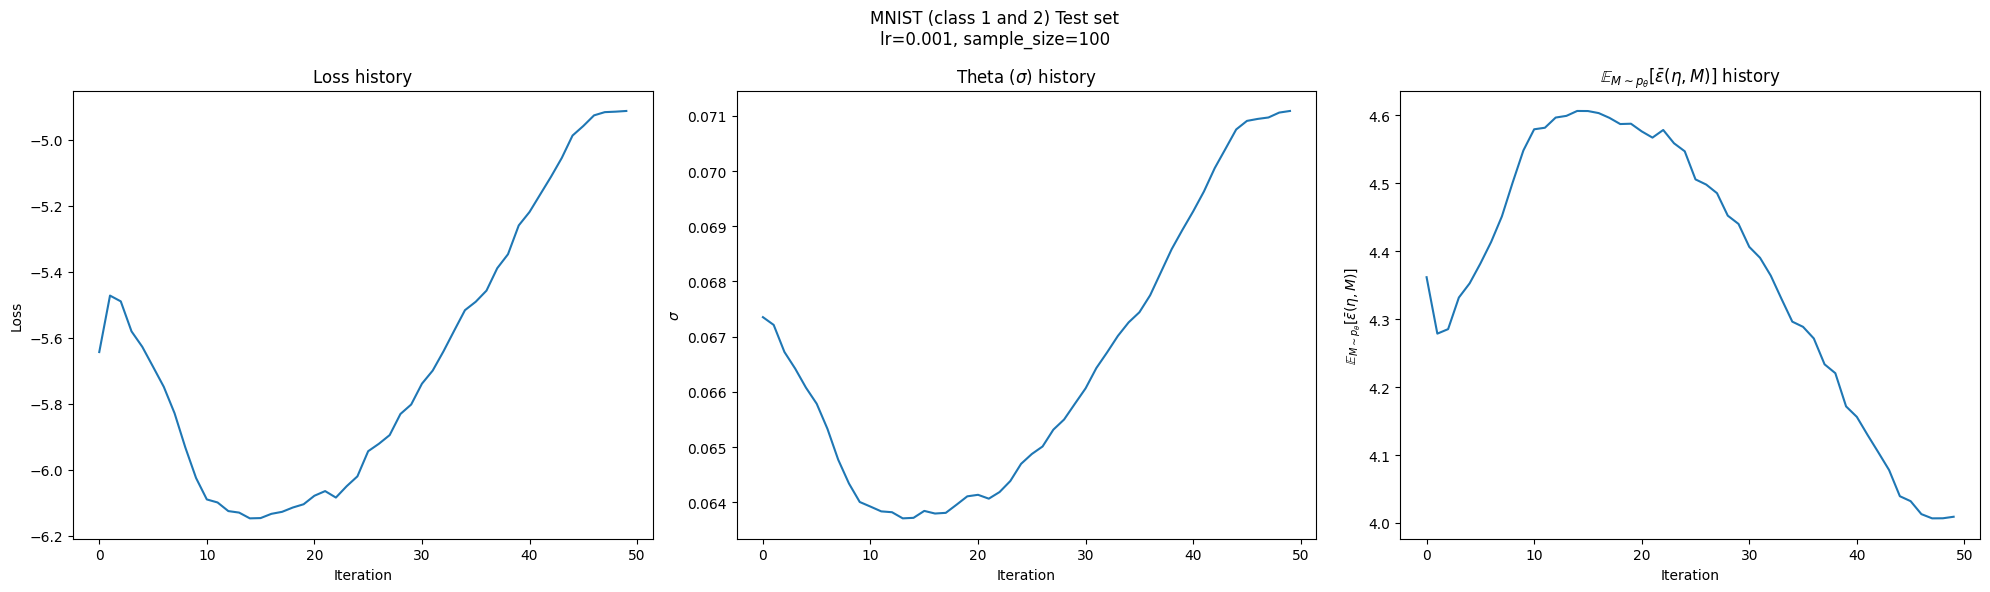

trial 3


  4%|▍         | 2/50 [38:32<15:24:23, 1155.48s/it, Loss=0.795, Theta=2.34, Epsilon=0.351]

In [8]:
sample_size = 100
lr = 0.001
epochs = 50

for trial in range(10):
    print('trial', trial)

    loss_history, theta_history, epsilon_history = train(sample_size=sample_size, lr=lr, epochs=epochs)

    fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 6))
    axes[0].set_title('Loss history')
    axes[0].plot(loss_history)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[1].set_title('Theta ($\sigma$) history')
    axes[1].plot(theta_history)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('$\sigma$')
    axes[2].set_title('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$ history')
    axes[2].plot(epsilon_history)
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('$\mathbb{E}_{M\sim p_\\theta}[\\bar{\epsilon}(\eta , M)]$')
    fig.suptitle(f'MNIST (class 1 and 2) Test set\nlr={lr}, sample_size={sample_size}')
    fig.tight_layout()
    plt.show()